/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


device cpu
device cpu


Tuning hyperparameters:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Tuning hyperparameters: 100%|██████████| 3/3 [27:38<00:00, 552.99s/it]


Best hyperparameters: {'hidden_structure': ((4, 256), (256, 256)), 'policy_head_structure': ((256, 2),), 'value_head_structure': ((256, 256), (256, 256), (256, 256), (256, 1)), 'lr': 0.001, 'gamma': 0.99, 'n_training_episodes': 300, 'max_t': 500}
Best regret: 73021.00


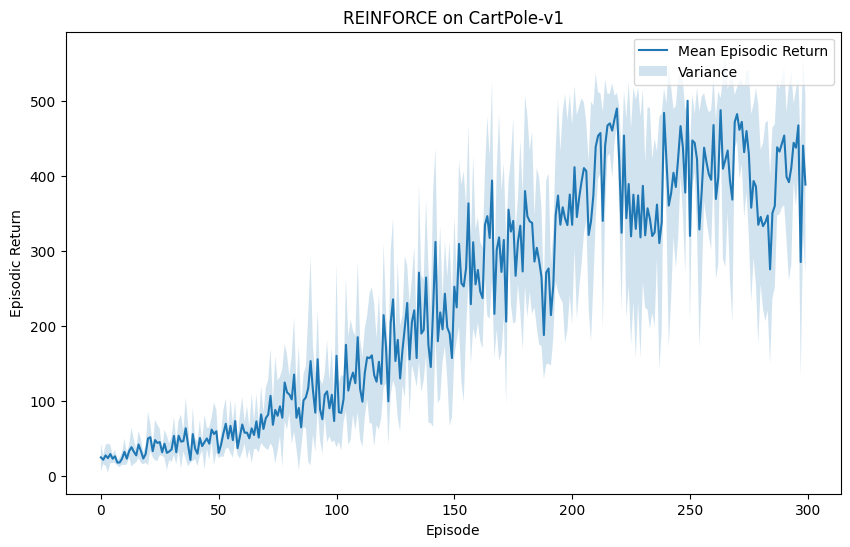

In [ ]:
import os.path
from datetime import datetime
from pathlib import Path
from typing import Tuple

import gym
import torch
import torch.nn.functional as F
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

class ReinforceNet(nn.Module):
    def __init__(self,
                 structure: Tuple[Tuple[int]],
                 policy_head_structure: Tuple[Tuple[int]],
                 value_head_structure: Tuple[Tuple[int]],
                 device):
        super(ReinforceNet, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(item[0], item[1]) for item in structure])
        self.policy_head = nn.ModuleList([nn.Linear(item[0], item[1]) for item in policy_head_structure])
        self.value_head = nn.ModuleList([nn.Linear(item[0], item[1]) for item in value_head_structure])

        self.to(device)

        for p in self.parameters():
            p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))

        policy = x
        for i, layer in enumerate(self.policy_head):
            policy = layer(policy)
            if i < len(self.policy_head) - 1:
                policy = F.relu(policy)
        policy = F.log_softmax(policy, dim=-1)

        value = x
        for i, layer in enumerate(self.value_head):
            value = layer(value)
            if i < len(self.value_head) - 1:
                value = F.relu(value)

        return policy, value


class REINFORCEAgent:
    def __init__(self,
                 environment,
                 hidden_structure: Tuple[Tuple[int]],
                 policy_head_structure: Tuple[Tuple[int]],
                 value_head_structure: Tuple[Tuple[int]],
                 lr: float,
                 gamma: float,
                 device,
                 look_back: int = 1):
        self.environment = environment
        self.look_back = look_back
        self.gamma = gamma
        self.network = ReinforceNet(hidden_structure, policy_head_structure, value_head_structure, device)
        self.optimizer = optim.AdamW(self.network.parameters(), lr=lr)
        self.scheduler = ExponentialLR(self.optimizer, gamma=0.99)
        self.loss_fun = torch.nn.MSELoss()
        self.device = device

    def learn(self, epoch, video):
        state = self.environment.reset()
        state = np.concatenate([state] * self.look_back)

        rewards_sum = 0
        rewards = []
        probabilities = []
        state_values = []
        counter = 0
        while True:
            if video:
                video.capture_frame()
            state = torch.from_numpy(state).flatten().to(self.device)
            actions_dist, state_value = self.network(state)
            state_values.append(state_value)
            action_dist = torch.distributions.Categorical(logits=actions_dist)
            action = action_dist.sample()
            probability = actions_dist[action]
            probabilities.append(probability)

            state, reward, episode_done, truncated = self.environment.step(action.item())
            state = np.concatenate([state] * self.look_back)
            rewards.append(reward)
            rewards_sum += reward
            counter += 1
            if episode_done or truncated:
                break

        probabilities = torch.stack(probabilities).flip(dims=(0,)).to(self.device)
        state_values = torch.stack(state_values).flip(dims=(0,)).flatten().to(self.device)

        returns = torch.Tensor(rewards).flip(dims=(0,)).to(self.device)
        for i in range(1, len(returns)):
            returns[i] = returns[i] + self.gamma * returns[i - 1]

        advantage = returns - state_values.detach()
        policy_loss = (- probabilities * advantage).sum()

        value_loss = self.loss_fun(state_values, returns)

        self.optimizer.zero_grad()
        (policy_loss + value_loss).backward()
        self.optimizer.step()

        if (epoch + 1) % 100 == 0:
            self.scheduler.step()

        return rewards_sum

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)

def tune_hyperparameters(env, state_size, action_size, n_training_episodes, max_steps, gamma):
    best_regret = float('inf')
    best_hyperparams = None

    # Define the hyperparameter search space
    learning_rates = [1e-4, 1e-3, 1e-2]
    hidden_sizes = [64, 128, 256]

    for lr in tqdm(learning_rates, desc="Tuning hyperparameters"):
        for h_size in hidden_sizes:
            hyperparams = {
                "hidden_structure": ((state_size, h_size), (h_size, h_size)),
                "policy_head_structure": ((h_size, action_size),),
                "value_head_structure": ((h_size, h_size), (h_size, h_size), (h_size, h_size), (h_size, 1)),
                "lr": lr,
                "gamma": gamma,
                "n_training_episodes": n_training_episodes,
                "max_t": max_steps,
            }

            agent = REINFORCEAgent(env,hyperparams["hidden_structure"],hyperparams["policy_head_structure"],hyperparams["value_head_structure"],hyperparams["lr"],0.99,device=device)
            episode_rewards = []
            for _ in range(n_training_episodes):
                total_reward = agent.learn(0, None)
                episode_rewards.append(total_reward)

            regret = n_training_episodes * max_steps - sum(episode_rewards)
            if regret < best_regret:
                best_regret = regret
                best_hyperparams = hyperparams

    return best_hyperparams, best_regret


def run_reinforce(best_hyperparams,num_seeds=5):
    all_episode_rewards = []
    for seed in range(num_seeds):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        agent = REINFORCEAgent(env,best_hyperparams["hidden_structure"],best_hyperparams["policy_head_structure"],best_hyperparams["value_head_structure"],best_hyperparams["lr"],best_hyperparams["gamma"],device=device)
        episode_rewards = []
        for epoch in range(best_hyperparams["n_training_episodes"]):
            total_reward = agent.learn(epoch, None)
            episode_rewards.append(total_reward)
        all_episode_rewards.append(episode_rewards)

    all_episode_rewards = np.array(all_episode_rewards)
    mean_episode_rewards = np.mean(all_episode_rewards, axis=0)
    std_episode_rewards = np.std(all_episode_rewards, axis=0)
    return mean_episode_rewards, std_episode_rewards


env = gym.make('CartPole-v1', render_mode='rgb_array')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)

observation_space = env.observation_space.shape[0] * look_back
action_space = env.action_space.n

best_hyperparams, best_regret = tune_hyperparameters(env, observation_space, action_space, 300, env.spec.max_episode_steps, gamma)
print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best regret: {best_regret:.2f}")

mean_episode_rewards, std_episode_rewards = run_reinforce(best_hyperparams)

plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_episode_rewards)), mean_episode_rewards, label='Mean Episodic Return')
plt.fill_between(range(len(mean_episode_rewards)), mean_episode_rewards - std_episode_rewards, mean_episode_rewards + std_episode_rewards, alpha=0.2, label='Variance')
plt.xlabel('Episode')
plt.ylabel('Episodic Return')
plt.title('REINFORCE on CartPole-v1')
plt.legend()
plt.show()

env.close()